In [4]:
import sys
import numpy as np
import matplotlib.pyplot as plt
import pickle
import tensorflow as tf

from model import ImageCaptionModel
from decoder import TransformerDecoder, RNNDecoder

from transformers.utils import logging
logging.set_verbosity_error() 

## Exploring the Dataset

In [5]:
## Before this, download the dataset and run preprocessing.py as instructed. 
## This may take like 10 mins, but should only happen once so ok.
## https://www.kaggle.com/datasets/adityajn105/flickr8k?resource=download

with open('../memes900k/data.p', 'rb') as data_file:
    data_dict = pickle.load(data_file)

# As mentioned in the handout, this assignment has 5 captions per image. This block of code 
# expands the image_feature lists to have 5 copies of each image to correspond to each of their captions 
feat_prep = lambda x: np.repeat(np.array(x).reshape(-1, 2048), 50, axis=0)
img_prep  = lambda x: np.repeat(x, 50, axis=0)

## Captions; preprocessed sentences with 20 window size
train_captions  = np.array(data_dict['train_captions']);            print('train_captions:  ', train_captions.shape)
test_captions   = np.array(data_dict['test_captions']);             print('test_captions:   ', test_captions.shape)

## 2048-D resnet embeddings of images.
train_img_feats = feat_prep(data_dict['train_image_features']);     print('\ntrain_img_feats: ', train_img_feats.shape)
test_img_feats  = feat_prep(data_dict['test_image_features']);      print('test_img_feats:  ', test_img_feats.shape)

## Small subset of actual images for visualization purposes. 
## These are just for the first 100 images of each (clones 5 times)
train_images    = img_prep(data_dict['train_images']);              print('\ntrain_images:    ', train_images.shape)
test_images     = img_prep(data_dict['test_images']);               print('test_images:     ', test_images.shape)

## Conversion dictionaries to go between word and label index
word2idx        = data_dict['word2idx']
idx2word        = data_dict['idx2word']

train_captions:   (12000, 21)
test_captions:    (3000, 21)

train_img_feats:  (12000, 2048)
test_img_feats:   (3000, 2048)

train_images:     (5000, 299, 299, 3)
test_images:      (3000, 299, 299, 3)


In [6]:
from read_glove import get_glove_embedding

embeddings_index = get_glove_embedding("../GloVE/glove.6B.300d.txt")
num_tokens = len(word2idx)
embedding_dim = 300
hits = 0
misses = 0
# Prepare embedding matrix
embedding_matrix = np.zeros((num_tokens, embedding_dim))
for word, i in word2idx.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # Words not found in embedding index will be all-zeros.
        # This includes the representation for "<start>" and "<end>" and "<unk>" and "<pad>"
        embedding_matrix[i] = embedding_vector
        hits += 1
    else:
        print(word)
        embedding_matrix[i] = tf.random.normal((embedding_dim, ))
        misses += 1
print("Converted %d words (%d misses)" % (hits, misses))

Found 400001 word vectors.
<start>
aaaand
<end>
<pad>
aaannd
aaaaand
aaaaaand
aaand
aaaaaaand
flappy
annddd
deathclaws
aaaaanddd
aaaaaaaaand
aaaaaaaaaaand
aaaaaaaand
waaay
inlove
nvm
guyz
roofie
faps
resturant
upvotes
downvotes
pokedex
upvote
hahah
proffesor
beiber
shits
shemale
skyrim
whaat
yeahhh
memegenerator
yesssssss
chatango
permisson
runscape
pornhub
meatspin
finnaly
omfg
wasent
cuck
christm
scho
challeng
anons
rubix
shabbirv
apears
butthurt
alergy
shitstorm
apocalipse
yourselfs
hypobromite
nabro
pawsitive
killstreak
fuuu
ffffuuuu
fffffffuuuuu
replys
fucktard
ermahgerd
roblox
friendzone
shouldnt
ahahahaha
handjob
srsly
bruhhh
fortnite
mutherfucker
bonasera
capish
girlies
snorlax
caterpie
wailord
doduo
koffing
diglett
fornite
dumbasses
lololol
shitloads
creampie
goooo
skyped
prety
unfollowed
dizer
jogar
reposts
dogshit
pssh
mckayla
obito
dafuq
gaaaaaaay
akward
cums
friendzoned
mastrubating
fapping
boyscouts
bday
monkies
winrar
safesearch
chiken
hahahaha
selfies
drunked
titties
sh

In [7]:
embedding_matrix.shape

(9954, 300)

Since the images take up a lot of data, we only kept a sliver of the original images. Feel free to update the preprocessing to retain all of the images if you'd like. Below is a visualization of some of the data:

Caption 1: <start> ll just play for few minutes before going to bed sep aaaand it dawn <end> <pad> <pad> <pad> <pad> <pad>
Caption 2: <start> had chance to win sep aaannd it gone <end> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad>
Caption 3: <start> weekend just started sep aaaaand it gone <end> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad>
Caption 4: <start> finally in relationship with the person you love sep aaaaaand its gone <end> <pad> <pad> <pad> <pad> <pad> <pad> <pad>
Caption 5: <start> poops reaches for toilet paper sep aaaaand it gone <end> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad>


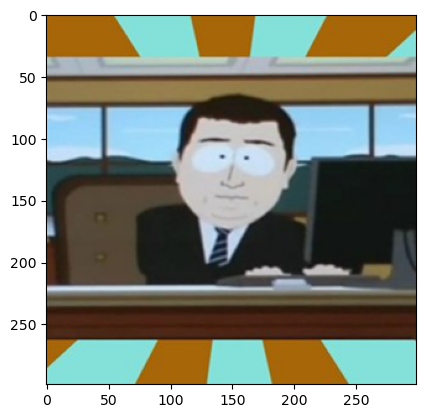

Caption 1: <start> generation sep the baby boomers cheated you out of billions and billions of dollars <end> <pad> <pad> <pad> <pad> <pad>
Caption 2: <start> happy birth day daniel sep welcome to the dirty club <end> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad>
Caption 3: <start> going to need you to take your opinion sep and shove it waaay up inside your butthole <end> <pad> <pad>
Caption 4: <start> cnn news sep finally respected journalist <end> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad>
Caption 5: <start> happy birthday sep gypsy bitch <end> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad>


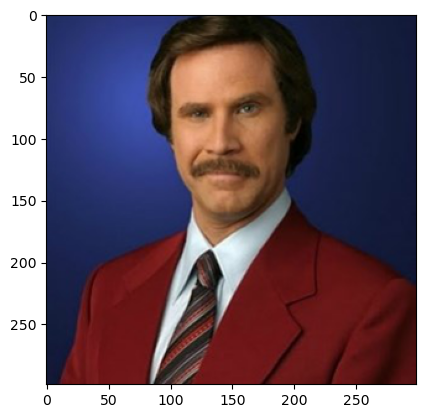

Caption 1: <start> has kid sep every single picture and status for the rest of her life is about having kid <end> <pad>
Caption 2: <start> invites you to be her friend sep never speaks to you <end> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad>
Caption 3: <start> makes profile picture sep omg am such good person <end> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad>
Caption 4: <start> has few drinks sep mis spells facebook status on purpose <end> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad>
Caption 5: <start> likes god on facebook sep omg such good christian <end> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad>


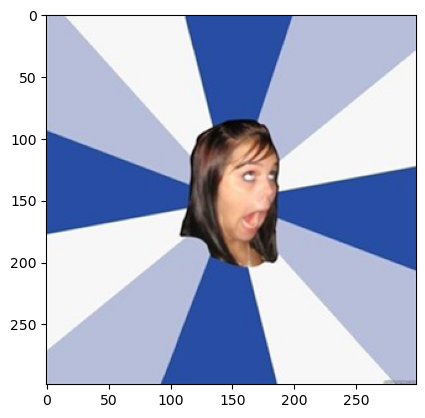

Caption 1: <start> sep dude it dead mau five <end> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad>
Caption 2: <start> smokes weed and listens to dark side of the moon sep on shuffle <end> <pad> <pad> <pad> <pad> <pad> <pad>
Caption 3: <start> scarface poster or bob marley poster sep decisions <end> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad>
Caption 4: <start> dj at party sep plays cd then just sits there <end> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad>
Caption 5: <start> lets drink tonight sep whos got money <end> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad>


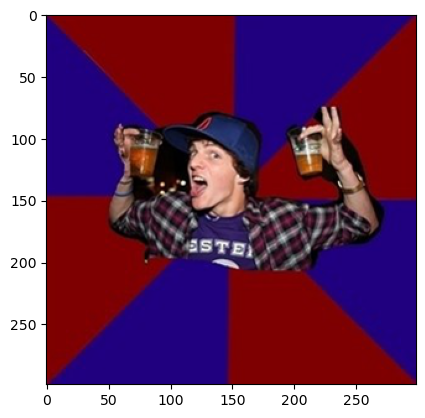

Caption 1: <start> what if oxygen is poisonous sep and takes years to kill us <end> <pad> <pad> <pad> <pad> <pad> <pad> <pad>
Caption 2: <start> what if really am the visitor sep and just missed out on free ipad <end> <pad> <pad> <pad> <pad> <pad>
Caption 3: <start> what if this meme has upvotes sep but the number of downvotes makes it seem really low <end> <pad> <pad>
Caption 4: <start> what if oxygen makes our voice deeper sep and helium brings it back to normal <end> <pad> <pad> <pad> <pad>
Caption 5: <start> what if the reason we have no visitors from the future sep is because we have no future <end> <pad>


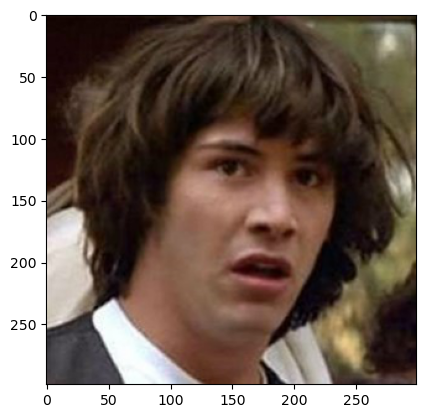

In [8]:
for i in range(5):
    for j in range(5):
        print(f'Caption {j+1}:', ' '.join([idx2word[idx] for idx in train_captions[i * 50 + j]]))
    plt.imshow(train_images[i * 50])
    plt.show()

### Running your RNN model

Depending on your use cases, you may choose to structure your model in a variety of ways. In contrast to previous assignments, this one is intended to mimic a lot of modern research-oriented repositories you might find in the wild. Specifically: **Instead of providing easy-to-use APIs for experimenters, they rigidify their implementation to make tests replicable.** Specifically, they may provide a command-line interface and define testing/training procedures which log results. 

(I mean, ideally you can make a flexible API and allow for both ease of extension and examples to demonstrate how your results were gathered, but sometimes researchers only have so much time...)

Once you have filled in the `model.py` components and the `RNNDecoder` of the `decoder.py` file, run this block to train your RNN model. As you can see, the hyperparamets default to the ones you use in `assignment.py`'s argparse specification, but feel free to change any of them to try to improve your model. 




In [8]:
## TODO: Increase epochs to a larger size when ready (maybe 2 or 3 would be enough?)
!python main.py --type rnn --task train --data ../memes900k/data.p --epochs 10 --chkpt_path ../rnn_model
## if using colab, you may need to do something like the following or might need to %cd into the directory of interest first...

Found 400001 word vectors.
Converted 9418 words (536 misses)

[Valid 1/30]	 loss=6.257	 acc: 0.184	 perp: 521.832
[Valid 2/30]	 loss=6.157	 acc: 0.186	 perp: 472.229
[Valid 3/30]	 loss=6.131	 acc: 0.196	 perp: 459.817
[Valid 4/30]	 loss=6.268	 acc: 0.198	 perp: 527.678
[Valid 5/30]	 loss=6.258	 acc: 0.202	 perp: 522.330
[Valid 6/30]	 loss=6.248	 acc: 0.208	 perp: 517.196
[Valid 7/30]	 loss=6.234	 acc: 0.206	 perp: 509.954
[Valid 8/30]	 loss=6.217	 acc: 0.214	 perp: 501.247
[Valid 9/30]	 loss=6.219	 acc: 0.210	 perp: 502.027
[Valid 10/30]	 loss=6.235	 acc: 0.208	 perp: 510.257
[Valid 11/30]	 loss=6.222	 acc: 0.202	 perp: 503.737
[Valid 12/30]	 loss=6.169	 acc: 0.199	 perp: 477.725
[Valid 13/30]	 loss=6.179	 acc: 0.198	 perp: 482.492
[Valid 14/30]	 loss=6.222	 acc: 0.198	 perp: 503.911
[Valid 15/30]	 loss=6.199	 acc: 0.197	 perp: 492.102
[Valid 16/30]	 loss=6.188	 acc: 0.196	 perp: 486.928
[Valid 17/30]	 loss=6.177	 acc: 0.193	 perp: 481.588
[Valid 18/30]	 loss=6.177	 acc: 0.196	 perp: 4

2024-05-04 19:23:47.218003: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.

2024-05-04 19:24:44.124212: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE SSE2 SSE3 SSE4.1 SSE4.2 AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.




### Running your Transformer model

Once you have completed the `transformer.py` file, run this block to train your transformer based model. Note that running with the `both` task will both train, save, and test your model in one go.

In [6]:
## TODO: Increase epochs to a larger size when ready (maybe 2 or 3 would be enough?)
!python main.py --type transformer --task train --data ../memes900k/data.p --epochs 10 --lr 0.0005 --chkpt_path ../transform_model

Found 400001 word vectors.
Converted 9418 words (536 misses)

[Valid 1/30]	 loss=6.338	 acc: 0.149	 perp: 565.564
[Valid 2/30]	 loss=6.226	 acc: 0.151	 perp: 505.972
[Valid 3/30]	 loss=6.206	 acc: 0.158	 perp: 495.629
[Valid 4/30]	 loss=6.332	 acc: 0.152	 perp: 562.180
[Valid 5/30]	 loss=6.325	 acc: 0.158	 perp: 558.090
[Valid 6/30]	 loss=6.312	 acc: 0.161	 perp: 551.151
[Valid 7/30]	 loss=6.299	 acc: 0.160	 perp: 544.036
[Valid 8/30]	 loss=6.295	 acc: 0.166	 perp: 542.107
[Valid 9/30]	 loss=6.305	 acc: 0.162	 perp: 547.436
[Valid 10/30]	 loss=6.320	 acc: 0.161	 perp: 555.683
[Valid 11/30]	 loss=6.307	 acc: 0.154	 perp: 548.625
[Valid 12/30]	 loss=6.252	 acc: 0.153	 perp: 519.277
[Valid 13/30]	 loss=6.263	 acc: 0.153	 perp: 524.538
[Valid 14/30]	 loss=6.302	 acc: 0.153	 perp: 545.494
[Valid 15/30]	 loss=6.281	 acc: 0.152	 perp: 534.268
[Valid 16/30]	 loss=6.272	 acc: 0.151	 perp: 529.755
[Valid 17/30]	 loss=6.260	 acc: 0.149	 perp: 523.227
[Valid 18/30]	 loss=6.260	 acc: 0.151	 perp: 5

2024-05-05 09:24:10.665331: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.

2024-05-05 09:25:29.079976: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE SSE2 SSE3 SSE4.1 SSE4.2 AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.





## Visualization

After training our Transformer model, you can visualize the self-attention layer to examine the behavior of your attention heads and see if any patterns emerge. 

To test out the components of the model interactively, you'll need to deconstruct selections of the model/runner code and get an instance of the model in an interactive context (aka inside the notebook). 



In [9]:
## Feel free to insert auto-reloads as necessary
from main import parse_args, load_model
from decoder import TransformerDecoder, RNNDecoder

## Pull your model into the notebook. This is heavily based off of assignment.py, 
## and feel free to reuse as much as you want. Your final project will probably 
## involve a lot of this investigative reverse-engineering based on what repos 
## you have to stumble upon.
## You're not in a notebook scenario, so use get_default_arguments and feel free to update it...

args = parse_args('--type rnn --task both --data ../memes900k/data.p'.split())

args.chkpt_path = '../transform_model'
tra_imcap = load_model(args)

args.chkpt_path = '../rnn_model'
rnn_imcap = load_model(args)





Model loaded from '../transform_model'
Model loaded from '../rnn_model'


In [10]:
rnn_imcap.summary()

Model: "image_caption_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rnn_decoder (RNNDecoder)    multiple                  7318254   
                                                                 
Total params: 7318254 (27.92 MB)
Trainable params: 7318254 (27.92 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [11]:
tra_imcap.summary()

Model: "image_caption_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 transformer_decoder (Trans  multiple                  7408554   
 formerDecoder)                                                  
                                                                 
Total params: 7408554 (28.26 MB)
Trainable params: 7408554 (28.26 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


### Caption Generation
Now that you have trained both of your models, it's time to use them to generate original captions for images in the testing set. First, the model is given the <start\> token and asked to generate probabilites for the next word in the sequence. The next token is chosen by sampling from that probability. This process repeats until the model generates the <end\> token, or the maximum sequence length is reached.

 



There is still one piece of this equation missing. The tokens are sampled from the probabilities your models generate, but your models were required to output logits, not probabilities. This is becasue this assignment, like many NLP models, uses temperature as a parameter in text generation. If the models sampled from  probabilies calculated by simply applying softmax to the logits, then the probability of the most likely word will usually be very high and the models will usually genrate the same, most probable caption every time. We use the temperature as a parameter to even out the probabilites so the model produces more 'creative' captions. This is done by dividing the logits by the temperature parameter before applying softmax. Higher temprature values will give a more creative captiong, while temprature values closer to 0 will be more greedy. Check out [this](https://lukesalamone.github.io/posts/what-is-temperature/) article for a demonstration and further explaination of temprature in NLP models.


In [12]:
def gen_caption_temperature(model, image_embedding, wordToIds, padID, temp, window_length):
    """
    Function used to generate a caption using an ImageCaptionModel given
    an image embedding. 
    """
    idsToWords = {id: word for word, id in wordToIds.items()}
    unk_token = wordToIds['<unk>']
    caption_so_far = [wordToIds['<start>']]
    while len(caption_so_far) < window_length and caption_so_far[-1] != wordToIds['<end>']:
        caption_input = np.array([caption_so_far + ((window_length - len(caption_so_far)) * [padID])])
        logits = model(np.expand_dims(image_embedding, 0), caption_input)
        logits = logits[0][len(caption_so_far) - 1]
        probs = tf.nn.softmax(logits / temp).numpy()
        next_token = unk_token
        attempts = 0
        while next_token == unk_token and attempts < 5:
            next_token = np.random.choice(len(probs), p=probs)
            attempts += 1
        caption_so_far.append(next_token)
    return ' '.join([idsToWords[x] for x in caption_so_far][1:-1])

## Generating Sentences for Training Data 

C1: didn find any hairs on your clothes last night sep are you dating bald girl
C2: dont give shit if shes your grandma sep stop seeing her
C3: always right sep especially on my period
C4: whos that girl who liked your status sep delete her
C5: why is your password sep not my name
RNN: you re gonna have you sep but that none of the shit
TRA: you know what you sep you


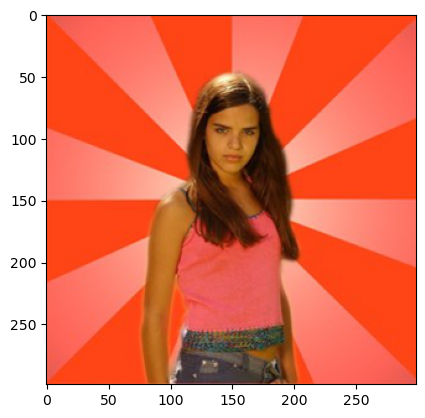

C1: know you re studying now sep so ll visit you after exams
C2: hey girl sep tell your husband to hire me as your pool boy ll keep it wet
C3: really wanted to be with lynda sep but forgot to pull out of eva
C4: go fuck yourself sep memegenerator
C5: hey girl miles ain sep got nothin on you
RNN: hey girl sep you re gonna have no power here
TRA: hey girl sep you re sexier


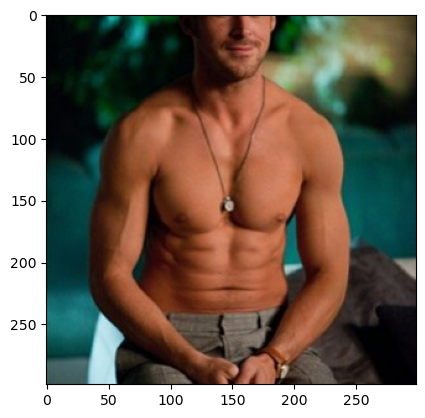

C1: emp sep my toe looks like vagina
C2: when cookie costs sep
C3: like sep muffins
C4: omg sep britney spears is single
C5: cnn news sep it that unwatchable
RNN: sep you can do you
TRA: emp sep you


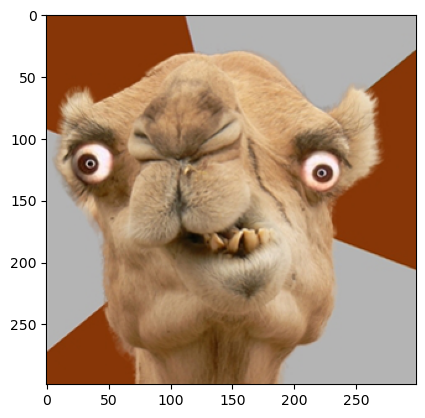

C1: so then told the officer sep can even walk when sober
C2: just saying sep dora explore her
C3: shit you not sep she said peekaboo then disappeared
C4: so tells her im hungry sep next thing know she stripping for me
C5: welcome sep to scotland
RNN: so you re telling me sep you re gonna have bad time
TRA: so then said sep and then said peekaboo


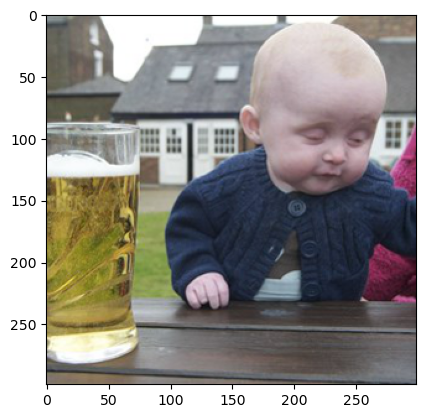

C1: just said my name was justin sep when it was actually billy im such hacker
C2: finally sep the wifi is working
C3: used the wrong meme image on purpose sep bet no one has ever thought of doing that before
C4: turned on the computer monitor sep such hacker
C5: yes sep just tricked the dnc to give me more passwords
RNN: can haz sep no
TRA: yes sep ll reply


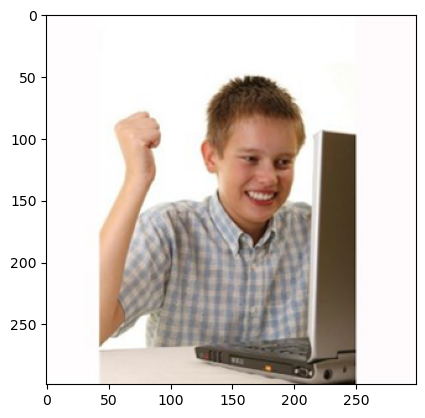

C1: joins club penguin sep doesn ask parents
C2: face you make when you fart sep right before leaving the elevator
C3: your crush walks by sep your face
C4: am sep spider man
C5: doesn spit nor swallow sep saves
RNN: don always know who sep but when you can do you think it means what you think it
TRA: emp sep you


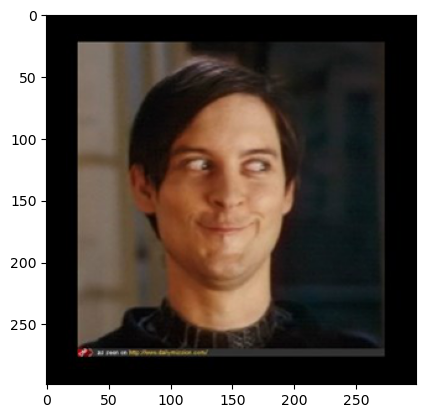

C1: look marge the oscars sep what the deal with donald trump
C2: you re home sep fuck
C3: look marge sep meme
C4: look marge liberal sep but muh feelings
C5: look marge sep blaming putin
RNN: look marge sep the fuck you
TRA: look marge sep look marge sep look marge sep look marge sep the information


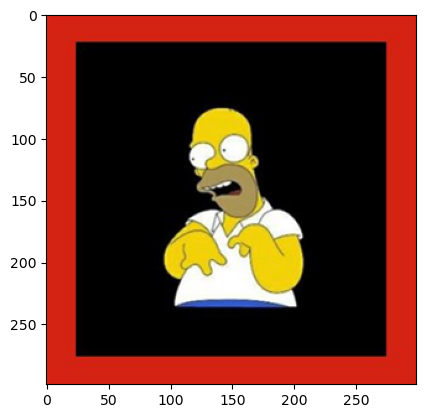

C1: lol you use windows sep that must be old have windows
C2: tries to search crush on facebook sep posts her name to wall
C3: apparently my registry is slow and infected with errors sep better do this instant free scan
C4: lives in my city sep and she wants me to have sex with her
C5: open command prompt sep certified hacker
RNN: goes to the internet sep gets an expert on the same day
TRA: computer sep with monitor


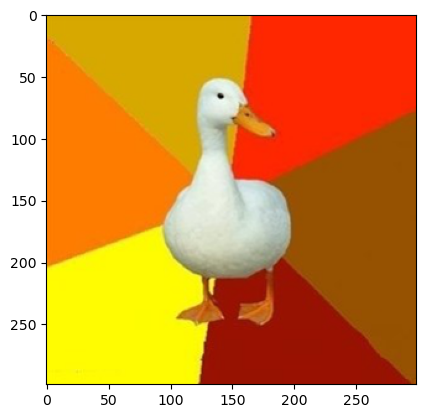

C1: trees sep they re just really really slow explosions
C2: when life gives you lemons sep have no idea where am right now
C3: how high are you sep yes
C4: cop says how high are you sep so say no its hi how are you
C5: get stoned sep watch bob ross paint
RNN: if you re not pass sep you re gonna have bad time
TRA: giraffe giraffe giraffe giraffe giraffe giraffe giraffe giraffe giraffe giraffe giraffe giraffe giraffe giraffe giraffe giraffe giraffe giraffe


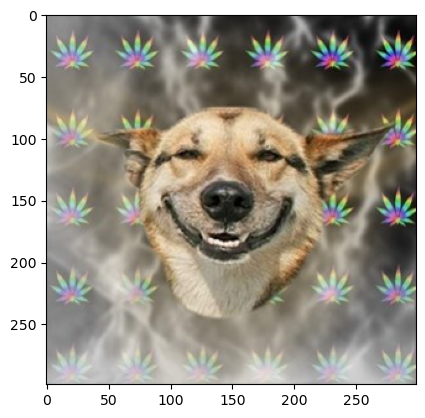

C1: winter is here sep you re fired
C2: brace yourself sep the teacher is coming
C3: brace yourself sep the shitty memes are coming
C4: finally it the season where sep the weather matches people hearts
C5: winter is coming wait not its not sep omg actually think its coming nope warm again
RNN: brace yourself sep the fuck is coming
TRA: brace yourselves sep the truth is coming


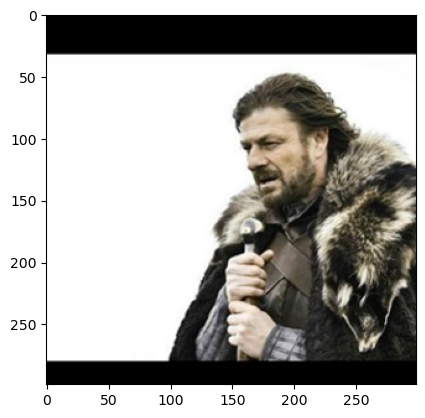

In [13]:
temperature = 0.1
indices = np.random.choice(np.array(list(range(0, 5000, 50))), 10, replace=False)
for i in indices:
    curr_image_feat = train_img_feats[i]
    curr_image      = train_images[i]
    for j in range(5):  ## Display all of the captions trained on
        words = [idx2word[x] for x in train_captions[i+j][:-1] if idx2word[x] not in ('<pad>', '<start>', '<end>')]
        print(f'C{j+1}:', ' '.join(words))
    print('RNN:', gen_caption_temperature(rnn_imcap, curr_image_feat, word2idx, word2idx['<pad>'], temperature, args.window_size))
    print('TRA:', gen_caption_temperature(tra_imcap, curr_image_feat, word2idx, word2idx['<pad>'], temperature, args.window_size))
    plt.imshow(curr_image)
    plt.show()

### Trying out on things in testing set!

385


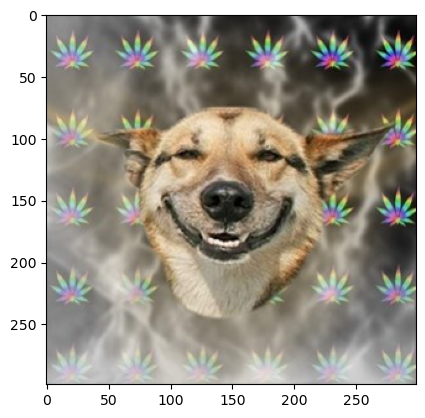

230


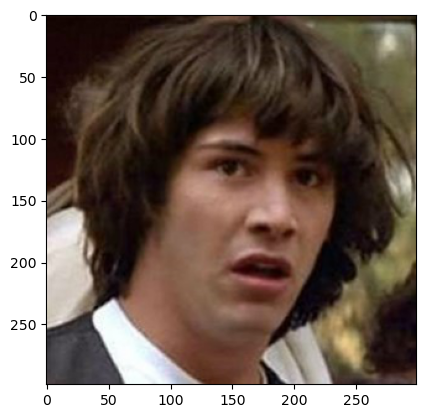

200


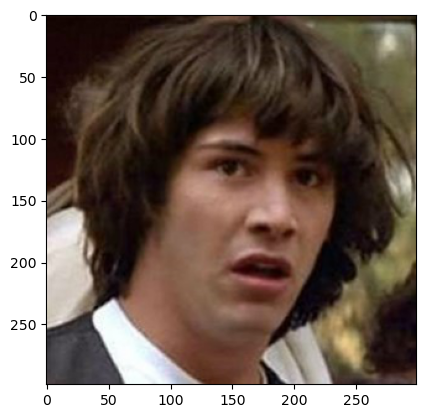

135


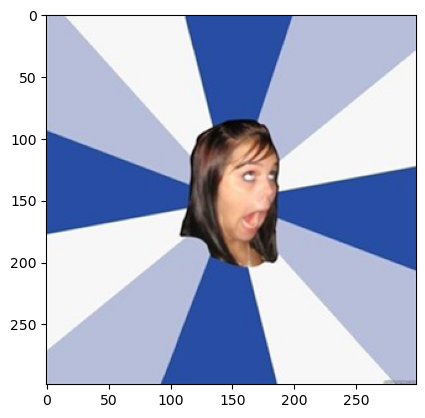

95


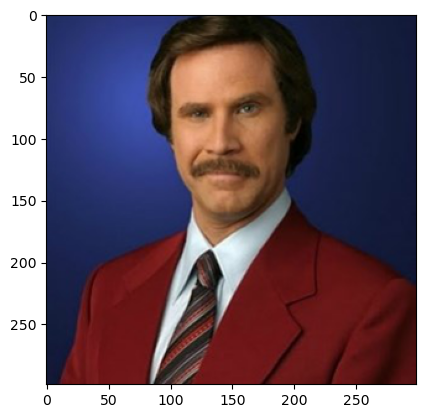

25


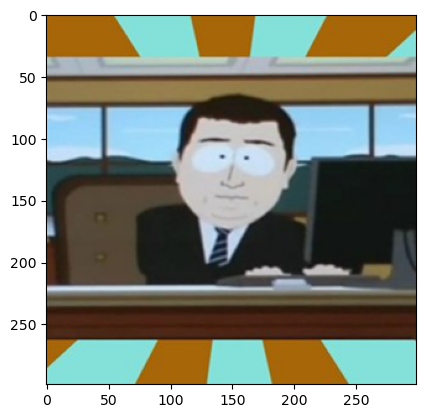

75


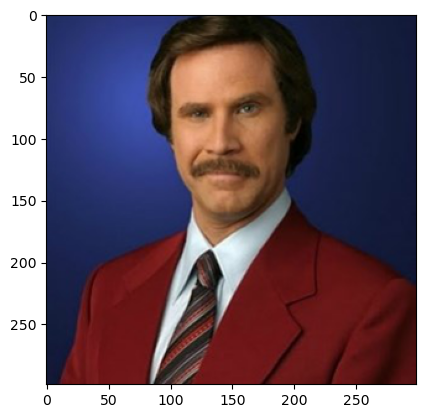

350


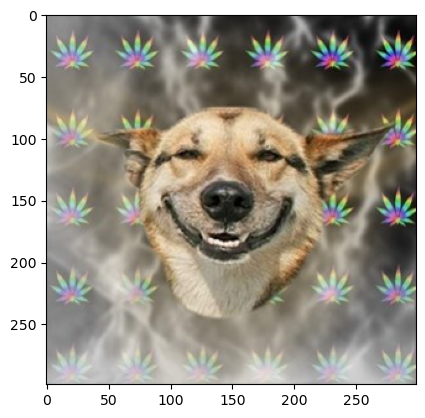

35


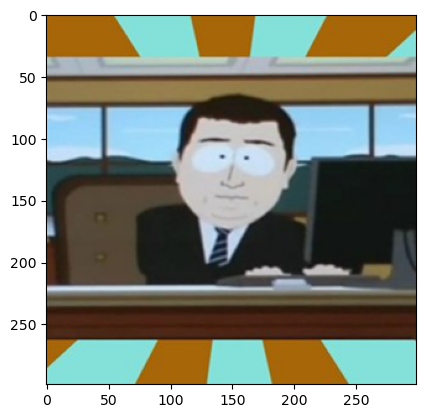

20


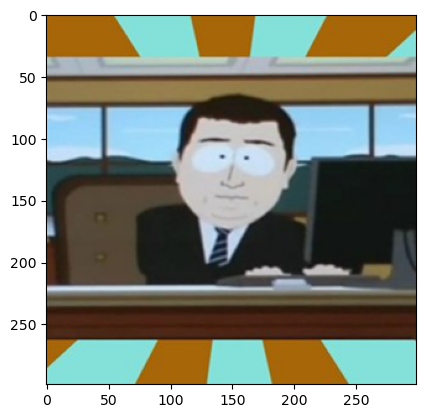

In [14]:
temperature = 0.2
indices = np.random.choice(np.array(list(range(0, 500, 5))), 10, replace=False)
rnn_captions = []
tra_captions = []

import warnings
warnings.filterwarnings("ignore", message=".*All model checkpoint layers were used.*")

for i in indices:
    print(i)
    curr_image_feat = train_img_feats[i]
    curr_image      = train_images[i]
    rnn_caption = gen_caption_temperature(rnn_imcap, curr_image_feat, word2idx, word2idx['<pad>'], temperature, args.window_size)
    tra_caption = gen_caption_temperature(tra_imcap, curr_image_feat, word2idx, word2idx['<pad>'], temperature, args.window_size)
    rnn_captions.append(rnn_caption)
    tra_captions.append(tra_caption)
    #output = rnn_imcap.get_offensive_score("Here")
    #text, offensive_score = rnn_imcap.get_unfiltered_captions(curr_image_feat, word2idx, word2idx['<pad>'], args.window_size)
    #print(text, "Offensive score: ", offensive_score)
    plt.imshow(curr_image)
    plt.show()

In [13]:
from filter_utils import print_captions_and_label
print_captions_and_label(tra_captions, "offensive")

#print_captions_and_label(["happy birthday sep you magnificent beast"], "offensive")

have no power here sep you have no power here
1) not-offensive 0.8513
2) offensive 0.1487

yes sep yes
1) not-offensive 0.8003
2) offensive 0.1997

drinks beer sep drinks beer
1) not-offensive 0.6577
2) offensive 0.3423

oh no sep no
1) not-offensive 0.7465
2) offensive 0.2535

happy birthday sep stay classy
1) not-offensive 0.8428
2) offensive 0.1572

happy birthday sep stay classy
1) not-offensive 0.8428
2) offensive 0.1572

this is sep you
1) not-offensive 0.8708
2) offensive 0.1292

what if the multiverse theory sep and the multiverse theory is the visitor
1) not-offensive 0.8635
2) offensive 0.1365

microsoft
1) not-offensive 0.7027
2) offensive 0.2973

happy birthday sep stay classy
1) not-offensive 0.8428
2) offensive 0.1572



In [16]:
indices = np.random.choice(np.array(list(range(0, 5000, 50))), 20, replace=False)

import warnings
warnings.filterwarnings("ignore", message=".*All model checkpoint layers were used.*")

unfiltered_offensive_score = []
average_filtered = []
filtered_offensive_score = []
average_unfiltered = []

for i in indices:
    print(i)
    curr_image_feat = train_img_feats[i]
    curr_image      = train_images[i]
    text1, offensive_score_un = tra_imcap.get_unfiltered_captions(curr_image_feat, word2idx, word2idx['<pad>'], args.window_size)
    unfiltered_offensive_score.append({text1, offensive_score_un})
    average_unfiltered.append(offensive_score_un)
    text2, offensive_score = tra_imcap.get_filtered_captions(curr_image_feat, word2idx, word2idx['<pad>'], args.window_size)
    filtered_offensive_score.append({text2, offensive_score})
    average_filtered.append(offensive_score)
    plt.imshow(curr_image)
    plt.show()


800


RuntimeError: Can't decrement id ref count (unable to extend file properly)

In [13]:
print("filtered offensive scores", average_filtered)
print("unfilted offensive scores", average_unfiltered)
print("filtered offensive score average: ", tf.reduce_sum(average_filtered) / 20.0)
print("unfilted offensive score average: ", tf.reduce_sum(average_unfiltered) / 20.0)

filtered offensive scores [0.0989486, 0.122690916, 0.23145954, 0.21434818, 0.29496887, 0.23056595, 0.23266718, 0.13790198, 0.28848103, 0.11265, 0.20662738, 0.20422971, 0.20601863, 0.17837027, 0.14871617, 0.16054808, 0.15565413, 0.101350546, 0.12789847, 0.21842092]
unfilted offensive scores [0.53004557, 0.122690916, 0.47727832, 0.2315949, 0.3750585, 0.2984823, 0.31702033, 0.13790198, 0.28848103, 0.22111185, 0.20662738, 0.84802437, 0.2763369, 0.8746177, 0.14871617, 0.16054808, 0.15565413, 0.08589599, 0.12789847, 0.21842092]
filtered offensive score average:  tf.Tensor(0.18362582, shape=(), dtype=float32)
unfilted offensive score average:  tf.Tensor(0.3051203, shape=(), dtype=float32)


In [2]:
!rm -rf cardiffnlp

2950


C:\Users\Administrator\AppData\Local\Temp\ipykernel_12232\2426290311.py:55: DeprecationWarning: getsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use getbbox or getlength instead.
  w, h = font.getsize(text)
C:\Users\Administrator\AppData\Local\Temp\ipykernel_12232\2426290311.py:131: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  w, h = draw.textsize(text, font)  # measure the size the text will take
C:\Users\Administrator\AppData\Local\Temp\ipykernel_12232\2426290311.py:131: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  w, h = draw.textsize(text, font)  # measure the size the text will take
C:\Users\Administrator\AppData\Local\Temp\ipykernel_12232\2426290311.py:109: DeprecationWarning: getsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use getbbox or getlength instead.
  lengths = list(ma

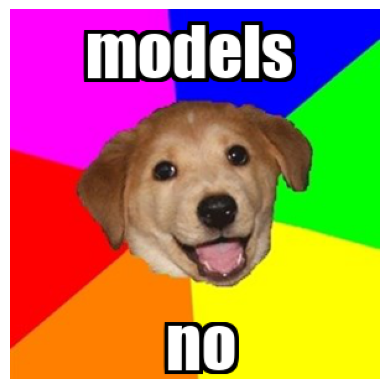

In [53]:
#@title Meme generation and captioning function

from PIL import Image
FONT_PATH = 'fonts/impact.ttf'
import numpy as np

temperature = 0.2
indices = np.random.choice(np.array(list(range(0, 5000, 50))), 1, replace=False)
plt.axis("off")

for i in indices:
    print(i)
    rnn_caption = gen_caption_temperature(rnn_imcap, curr_image_feat, word2idx, word2idx['<pad>'], temperature, args.window_size)
    tra_caption = gen_caption_temperature(tra_imcap, curr_image_feat, word2idx, word2idx['<pad>'], temperature, args.window_size)
    
    curr_image_feat = train_img_feats[i]
    curr_image      = train_images[i]
    if len(tra_caption.split("sep")) == 1:
        bottom_caption = tra_caption.split("sep")[0]
        top_caption = ''
    else:
        bottom_caption = tra_caption.split("sep")[1]
        top_caption = tra_caption.split("sep")[0]
    img = Image.fromarray(curr_image) # 
    output = memeify_image(img, top_caption, bottom_caption, font_path=FONT_PATH)
    plt.imshow(output)
    #plt.figure(figsize=(299, 299))
    plt.savefig("image1.png", bbox_inches=)
    

In [21]:
import numpy as np
from PIL import ImageFont, ImageDraw
from copy import deepcopy


MEME_FONT_PATH = 'fonts/impact.ttf'


def memeify_image(img, top='', bottom='', font_path=MEME_FONT_PATH):
    """Adds top and bottom captions to an image.

    Args:
        img (PIL.Image): input image
        top (str): top caption text
        bottom (str): top caption text
        font_path (str): path to font

    Returns:
        PIL.Image: captioned image
    """
    # do not change existing image
    img = deepcopy(img)

    # initial font
    font = _get_initial_font(img, texts=[top, bottom], font_path=font_path)

    # split texts into lines
    top_lines = split_to_lines(img, top, font)
    bottom_lines = split_to_lines(img, bottom, font)

    # adjust the font
    font = _get_final_font(img, [top_lines, bottom_lines], font_path=font_path)

    # caption image with both texts
    img = caption_image(img, top_lines, font, 'top')
    img = caption_image(img, bottom_lines, font, 'bottom')

    return img


def get_maximal_font(img, text, font_size=64, text_width=0.94, font_path=MEME_FONT_PATH):
    """Computes the font of maximal size that fits the text.

    Args:
        img (PIL.Image): input image
        text (str): text to fit into image
        font_size (int): initial font size
        text_width (float): text width ratio with respect to image width
        font_path (str): path to font

    Returns:
        PIL.ImageFont: optimal font
    """
    font = ImageFont.truetype(font_path, font_size)
    w, h = font.getsize(text)

    # find the biggest font size that works
    while w > img.width * text_width:
        font_size = font_size - 1
        font = ImageFont.truetype(font_path, font_size)
        w, h = font.getsize(text)

    return font


def _get_initial_font(img, texts, max_chars=20, font_path=MEME_FONT_PATH):
    """Compute initial font of maximal size based of texts.

    Args:
        img (PIL.Image): input image
        texts (List[str]): list of texts
        max_chars (int): maximum number of characters in a line
        font_path (str): path to font

    Returns:
        PIL.ImageFont: optimal font
    """
    # compute the maximum number of characters in a line
    max_len = max(map(len, texts))
    max_len = max_len if max_len < max_chars else max_chars
    longest_text = 'G' * max_len

    # get initial font size from image dimensions
    font_size = int(img.height / 5.4)

    # get maximal font for the initial text
    font = get_maximal_font(img, longest_text, font_size, font_path=font_path)

    return font


def _get_final_font(img, text_lines, font_path=MEME_FONT_PATH):
    """Compute final font of maximal size based of texts split into lines.

    Args:
        img (PIL.Image): input image
        text_lines (List[List[str]]): list of list of text lines
        font_path (str): path to font

    Returns:
        PIL.ImageFont: optimal font
    """
    # initial font size
    font_size = int(img.height / 5.4) // max(map(len, text_lines))
    font = ImageFont.truetype(font_path, font_size)

    # find the text with the highest occupied width
    text_lines = [text for lines in text_lines for text in lines]
    lengths = list(map(lambda x: font.getsize(x)[0], text_lines))
    longest_text = text_lines[np.argmax(lengths)]

    # get maximal font for the text with highest width
    font = get_maximal_font(img, longest_text, font_size, font_path=font_path)

    return font


def split_to_lines(img, text, font):
    """Splits text into lines to fit the image with a given font.

    Args:
        img (PIL.Image): input image
        text (str): input text
        font (PIL.ImageFont): text font

    Returns:
        List[str]: list of text lines
    """
    draw = ImageDraw.Draw(img)
    #text = text.replace('', '').upper()
    w, h = draw.textsize(text, font)  # measure the size the text will take

    # compute the number of lines
    line_count = 1
    if w > img.width:
        line_count = w // img.width + 1

    lines = []
    if line_count > 1:
        # cut text into lines preserving words

        last_cut = 0
        is_last = False

        for i in range(0, line_count):
            cut = (len(text) // line_count) * i if last_cut == 0 else last_cut

            if i < line_count - 1:
                next_cut = (len(text) // line_count) * (i + 1)
            else:
                next_cut = len(text)
                is_last = True

            # make sure we don't cut words in half
            if not (next_cut == len(text) or text[next_cut] == " "):
                while text[next_cut] != " ":
                    next_cut += 1

            line = text[cut:next_cut].strip()

            # does line still fit?
            w, h = draw.textsize(line, font)
            if not is_last and w > img.width * 0.95:
                next_cut -= 1
                while text[next_cut] != " ":
                    next_cut -= 1

            last_cut = next_cut
            lines.append(text[cut:next_cut].strip())
    else:
        lines.append(text)

    return lines


def caption_image(img, text_lines, font, pos='top'):
    """Captions the image with text.

    Args:
        img (PIL.Image): input image
        text_lines (List[str]): list of text lines
        font (PIL.ImageFont): text font
        pos (str): position of text (`top` or `bottom`)

    Returns:
        PIL.Image: captioned image
    """
    draw = ImageDraw.Draw(img)
    w, h = draw.textsize(text_lines[0], font)  # measure the size the text will take

    # text border size
    border_size = font.size // 18

    # compute the position of text on y-axis
    last_y = -h
    if pos == 'bottom':
        last_y = img.width * 0.987 - h * (len(text_lines) + 1) - border_size

    # draw text lines
    for line in text_lines:
        w, h = draw.textsize(line, font)
        x = img.width / 2 - w / 2
        y = last_y + h

        # add borders of black color
        for xx in range(-border_size, border_size + 1):
            for yy in range(-border_size, border_size + 1):
                draw.text((x + xx, y + yy), line, (0, 0, 0), font=font)

        # add text in white
        draw.text((x, y), line, (255, 255, 255), font=font)

        last_y = y

    return img

In [18]:
!pip install Pillow==9.5.0